In [116]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from sklearn.utils import shuffle

# Define custom dataset class
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []  # List to hold (image_path, label) tuples
        
        # Assuming real images are in 'real' folder and AI-generated images are in 'ai_generated' folder
        real_images = glob.glob(os.path.join(root_dir, 'real_images', '*.jpg'))
        ai_images = glob.glob(os.path.join(root_dir, 'ai_images', '*.png'))
        
        # Assign label 0 to real images and label 1 to AI-generated images
        self.data.extend([(img_path, 0) for img_path in real_images])
        
        # Shuffle and duplicate AI-generated images to balance the dataset
        ai_images = shuffle(ai_images)
        num_real_images = len(real_images)
        ai_images = ai_images[:num_real_images]  # Keep only as many as real images

        print(f"Number of ai images : {len(ai_images)}")
        print(f"Number of real images : {num_real_images}")
        
        self.data.extend([(img_path, 1) for img_path in ai_images])
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
            
        return img, label

# Data transformations and augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset instance
dataset = CustomDataset(root_dir='/Users/nitinnandansingh/Documents/workspace/AIImageClassifier/assets/images', transform=train_transform)
print(len(dataset))
# Split dataset into train, validation, and test sets
train_size = int(0.9 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size
# test_size = len(dataset) - train_size

# print(train_size, test_size)
# train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

print(len(train_set))
print(len(val_set))
print(len(test_set))



Number of ai images : 3150
Number of real images : 3449
6599
5939
329
331


In [117]:
# Create data loaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

# Load pre-trained ResNet50 model
model = models.resnet50(pretrained=True)

layers_to_train = ['layer4', 'fc']

for name, param in model.named_parameters():
    if any(layer in name for layer in layers_to_train):
        param.requires_grad = True


# # Freeze all pre-trained layers
# for param in model.parameters():
#     param.requires_grad = False
# print(model)
# Replace the final fully connected layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Output 2 classes (real or AI-generated)
print(model)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [118]:
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")

torch.save(model.state_dict(), "/Users/nitinnandansingh/Documents/workspace/AIImageClassifier/saved_models/resnet50_v3_model.pth")

# Test the model on val set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Val Accuracy: {accuracy:.4f}")


model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/10, Train Loss: 0.1767
Epoch 2/10, Train Loss: 0.0926
Epoch 3/10, Train Loss: 0.0849
Epoch 4/10, Train Loss: 0.0670
Epoch 5/10, Train Loss: 0.0659
Epoch 6/10, Train Loss: 0.0640


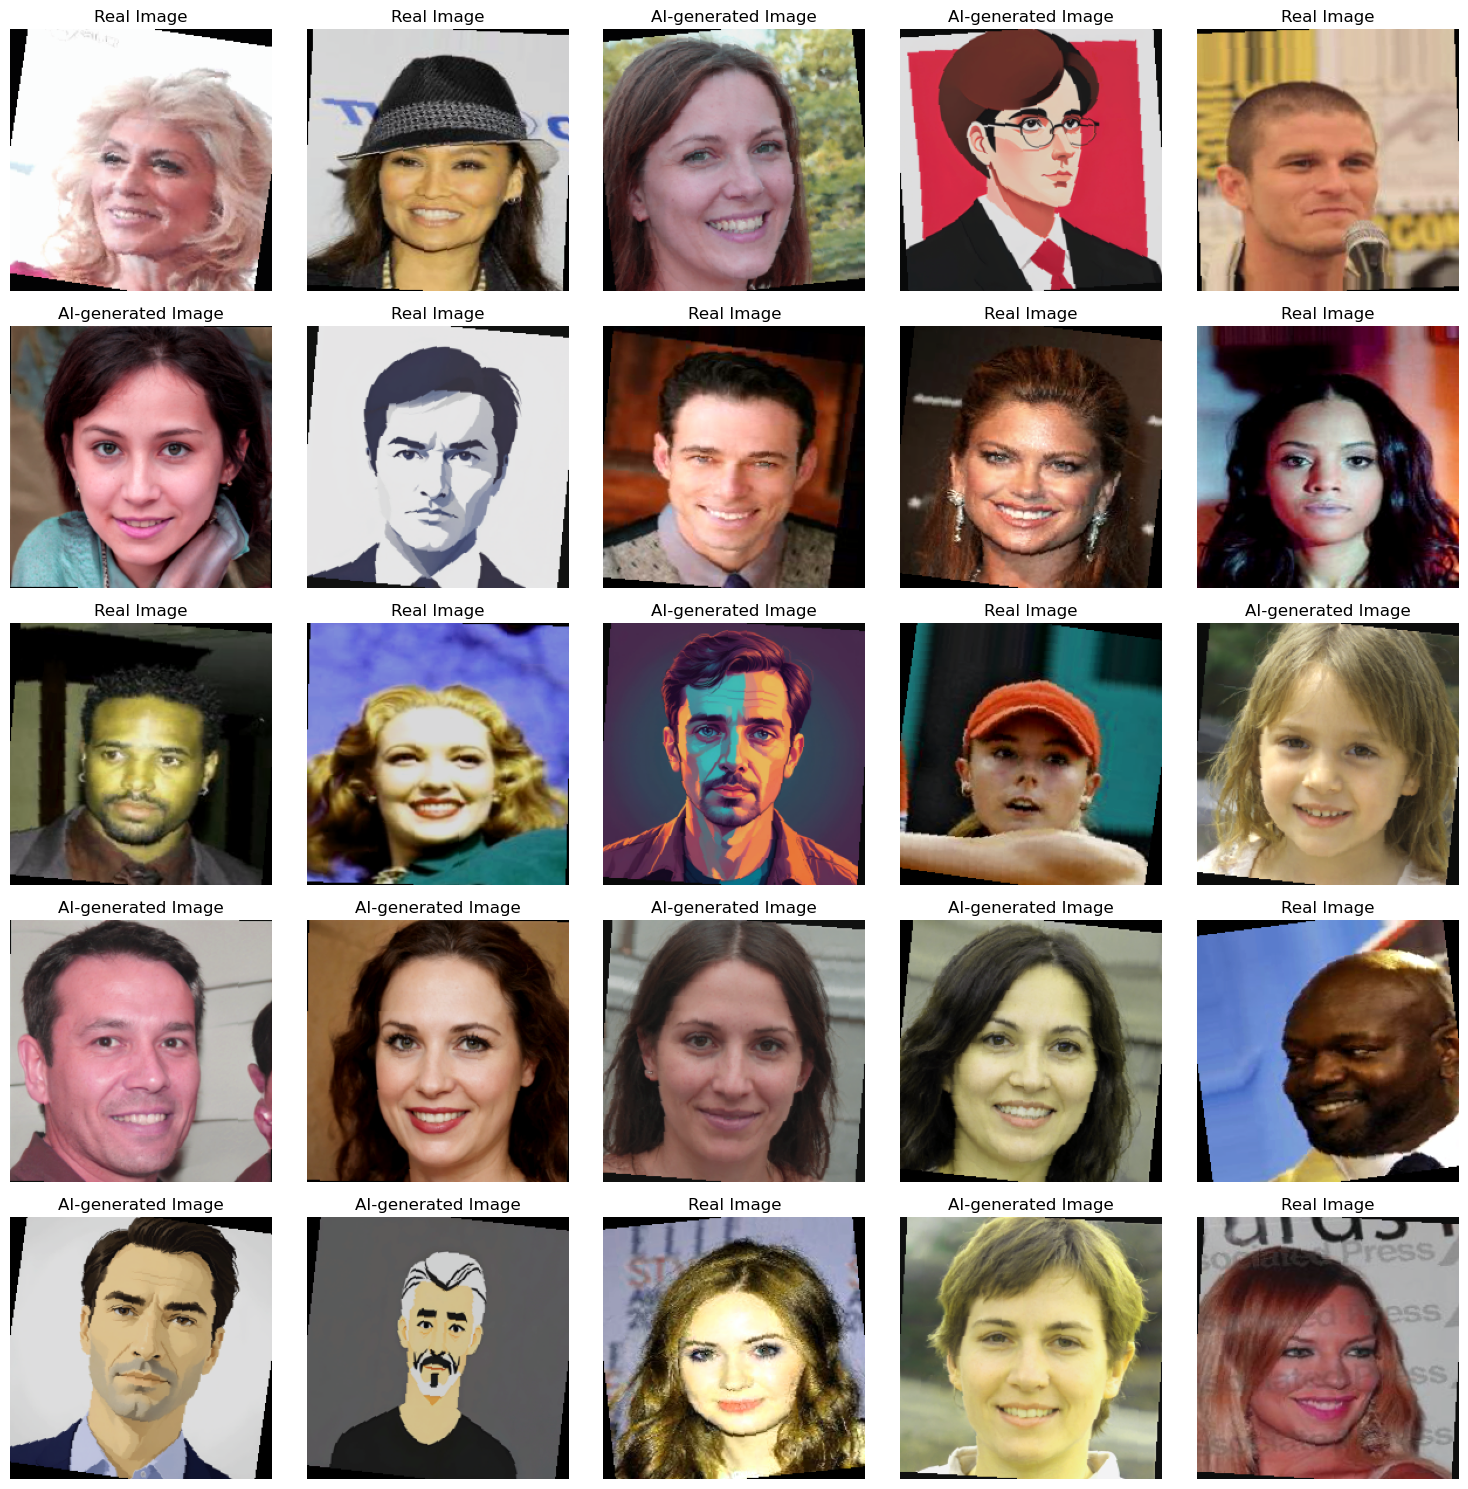

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# Function to reverse normalize the image tensor
def reverse_normalize(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    return image

# Set model to evaluation mode
model.eval()

# Initialize lists to store images and predicted labels
images = []
predicted_labels = []

# Iterate over the test loader and make predictions
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        # Convert tensors to numpy arrays
        inputs = inputs.numpy()
        labels = labels.numpy()
        predicted = predicted.numpy()
        
        # Reverse normalize and store each image with predicted label
        for i in range(len(inputs)):
            image = reverse_normalize(inputs[i].transpose(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
            images.append(image)
            if predicted[i] == 0:
                predicted_labels.append("Real Image")
            else:
                predicted_labels.append("AI-generated Image")

# Plot images in a grid of 5x5 with predicted labels as titles
num_images = len(images)
num_rows = 5
num_cols = 5

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))

for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        if index < num_images:
            axs[i, j].imshow(images[index])
            axs[i, j].set_title(predicted_labels[index])
            axs[i, j].axis('off')

plt.tight_layout()
plt.show()


In [108]:
import torch
from torchvision import transforms
from PIL import Image

# Define the path to your test image
image_path = '/Users/nitinnandansingh/Documents/workspace/AIImageClassifier/assets/test_sample/srk_real.jpeg'

# Define the transformation to be applied to the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size expected by your model
    transforms.ToTensor(),          # Convert image to tensor and normalize
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the image
image = Image.open(image_path)
input_tensor = transform(image)
input_tensor = input_tensor.unsqueeze(0)  # Add a batch dimension

# Move the input tensor to the appropriate device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)

# Set the model to evaluation mode
model.eval()

# Perform inference to get the predicted class probabilities
with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted = torch.max(outputs, 1)

# Assuming your model outputs class indices (0 for Real, 1 for AI-generated)
if predicted.item() == 0:
    predicted_label = "Real Image"
else:
    predicted_label = "AI-generated Image"

# Display the predicted label
print("Predicted Label:", predicted_label)


Predicted Label: AI-generated Image


In [85]:
import gradio as gr
import torch
from torchvision import transforms
from PIL import Image

# Load your trained model
# model = torch.load("path_to_your_model.pth", map_location=torch.device('cpu'))  # Load on CPU

# Define transformation for input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def classify_image(image):
    # Preprocess the input image
    input_tensor = transform(Image.fromarray(image))
    input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension

    # Perform inference
    with torch.no_grad():
        model.eval()
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)

    # Return prediction label
    return "Real Image" if predicted.item() == 0 else "AI-generated Image"

# Define Gradio interface
# image_input = gr.inputs.Image()
# label_output = gr.outputs.Textbox()

# # Create Gradio app
# gr.Interface(fn=classify_image, inputs=image_input, outputs=label_output).launch()

gr.Interface(fn=classify_image,
             inputs=gr.Image(),
             outputs=gr.Label(num_top_classes=2),
             examples=["/Users/nitinnandansingh/Documents/workspace/AIImageClassifier/assets/test_sample/ajay_fake.jpeg", "/Users/nitinnandansingh/Documents/workspace/AIImageClassifier/assets/test_sample/srk_real.jpeg"]).launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


In [90]:
# Load your trained model state dictionary
model_path = '/Users/nitinnandansingh/Documents/workspace/AIImageClassifier/saved_models/resnet50_v1_model.pth'
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))

# Inspect checkpoint keys to identify the correct key for the model state dictionary
print(checkpoint.keys())

# # Instantiate the model (assuming it's a ResNet-50)
# model = models.resnet50(pretrained=False)
# num_classes = 2  # Assuming 2 classes: Real Image and AI-generated Image
# model.fc = torch.nn.Linear(model.fc.in_features, num_classes)  # Modify fully connected layer

# # Identify the correct key for the model state dictionary and load state into model
# model_key = 'state_dict'  # Modify this based on checkpoint keys
# model.load_state_dict(checkpoint[model_key])

# # Set model to evaluation mode
# model.eval()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.we

In [110]:
input_folder = '/Users/nitinnandansingh/Documents/workspace/AIImageClassifier/assets/images/ai_images'
output_folder = '/Users/nitinnandansingh/Documents/workspace/AIImageClassifier/assets/images/ai_images'
for filename in os.listdir(input_folder):
    if filename.endswith(".jpg"):
        # Open the image file
        with Image.open(os.path.join(input_folder, filename)) as img:
            # Generate the output filename
            output_filename = os.path.splitext(filename)[0] + ".png"
            # Save as PNG in the output folder
            img.save(os.path.join(output_folder, output_filename), "PNG")
            # print(f"Converted: {filename} -> {output_filename}")

In [98]:
file_error = '/Users/nitinnandansingh/Documents/workspace/AIImageClassifier/assets/images/ai_images/seed300976.png'
!ls -l /Users/nitinnandansingh/Documents/workspace/AIImageClassifier/assets/images/ai_images/seed300976.png


-rw-rw-r--@ 1 nitinnandansingh  staff  1377116 Sep 22  2022 /Users/nitinnandansingh/Documents/workspace/AIImageClassifier/assets/images/ai_images/seed300976.png


In [100]:
!ls -l /Users/nitinnandansingh/Documents/workspace/AIImageClassifier/assets/images/ai_images/seed300203.png

-rw-rw-r--@ 1 nitinnandansingh  staff  1219765 Sep 22  2022 /Users/nitinnandansingh/Documents/workspace/AIImageClassifier/assets/images/ai_images/seed300203.png


In [102]:
import os
def check_file_permissions(file_path):
   if os.access(file_path, os.R_OK):
      print(f"Read permission is granted for file: {file_path}")
   else:
      print(f"Read permission is not granted for file: {file_path}")
    
   if os.access(file_path, os.W_OK):
      print(f"Write permission is granted for file: {file_path}")

   else:
      print(f"Write permission is not granted for file: {file_path}")
    
   if os.access(file_path, os.X_OK):
      print(f"Execute permission is granted for file: {file_path}")
   else:

      print(f"Execute permission is not granted for file: {file_path}")
# Example usage
# file_path = "path/to/file.txt"
check_file_permissions('/Users/nitinnandansingh/Documents/workspace/AIImageClassifier/assets/images/ai_images/seed300203.png')

Read permission is granted for file: /Users/nitinnandansingh/Documents/workspace/AIImageClassifier/assets/images/ai_images/seed300203.png
Write permission is granted for file: /Users/nitinnandansingh/Documents/workspace/AIImageClassifier/assets/images/ai_images/seed300203.png
Execute permission is not granted for file: /Users/nitinnandansingh/Documents/workspace/AIImageClassifier/assets/images/ai_images/seed300203.png


In [103]:
!lsof /Users/nitinnandansingh/Documents/workspace/AIImageClassifier/assets/images/ai_images/seed300976.png


COMMAND     PID             USER   FD   TYPE DEVICE SIZE/OFF     NODE NAME
Code\x20H 62469 nitinnandansingh   29r   REG   1,18  1377116 67606023 /Users/nitinnandansingh/Documents/workspace/AIImageClassifier/assets/images/ai_images/seed300976.png
